# Applying ML Regression Algorithms: Enhancing models through Column Transformers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

import sys
sys.path.append('..')
from modules.model_evaluator import run_cv_reg
from modules.plotter import plot_model_eval

In [2]:
root = '../data/regression/cars_reg.csv'

df = pd.read_csv(root)

df.head()

,co2_emiss,height,length,max_speed,mixed_cons,weight,tank_vol,acc,price,gearbox_Automatic,...,doors_2,doors_3,doors_4,doors_5,brand_encoded,model_encoded,city_encoded,color_encoded,type_encoded,chassis_encoded
0,99,157,270,145,4.3,780,33,13.7,5500,1.0,...,1.0,0.0,0.0,0.0,11039.980916,10171.125628,15841.032810,16998.492107,28133.811134,20602.196957
1,179,140,426,235,7.6,1373,55,7.2,10900,0.0,...,0.0,1.0,0.0,0.0,17051.258362,13160.993789,18049.881613,16998.492107,28133.811134,31238.629315
2,109,142,453,222,4.2,1545,42,8.5,36100,1.0,...,0.0,0.0,1.0,0.0,23572.093803,23508.383973,18554.493671,21242.844857,28133.811134,31238.629315
3,142,162,467,212,5.4,1740,67,8.0,28000,1.0,...,0.0,0.0,0.0,1.0,23572.093803,36412.589552,16569.441935,16998.492107,28133.811134,31238.629315
4,488,123,446,189,21.0,1546,70,3.9,27990,1.0,...,1.0,0.0,0.0,0.0,12506.369048,17773.464491,17306.168324,17415.598758,28133.811134,31238.629315


In [3]:
# Diving data into features & target (price)
X = df.drop('price', axis=1)
y = df['price']

In [4]:
# Listing models
models = []
models.append(('RF', RandomForestRegressor()))
models.append(('XGB', xgb.XGBRegressor()))
models.append(('CB', CatBoostRegressor(verbose=False)))

## Performance without Column Transformations

In [5]:
df_models, results = run_cv_reg(X, y, models, evaluator='r2')
df_models

Executing RF...
CV finished for RF
Executing XGB...
CV finished for XGB
Executing CB...
CV finished for CB


,model,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec
0,RF,0.8767,0.8783,0.8851,0.8841,0.0056,0.8874,0.8939,302.1931
1,XGB,0.8627,0.8688,0.8734,0.8724,0.0055,0.8757,0.8807,17.9531
2,CB,0.8609,0.8664,0.8701,0.8703,0.0054,0.8748,0.8793,93.5536


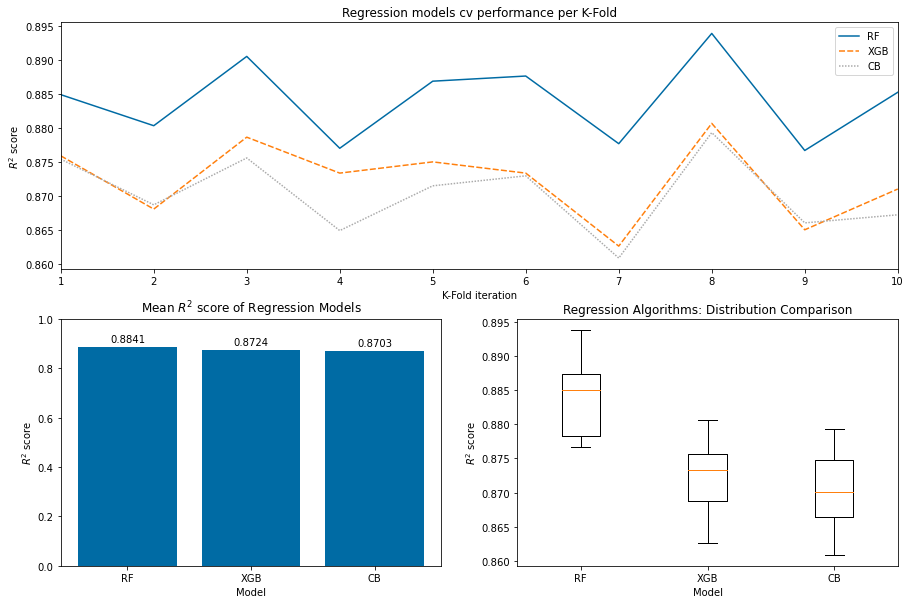

In [6]:
plot_model_eval(df=df_models, results=results)

## Performance with Column Transformations: Quantile Transformer

### Transforming only the features

In [7]:
rng = np.random.RandomState(33)

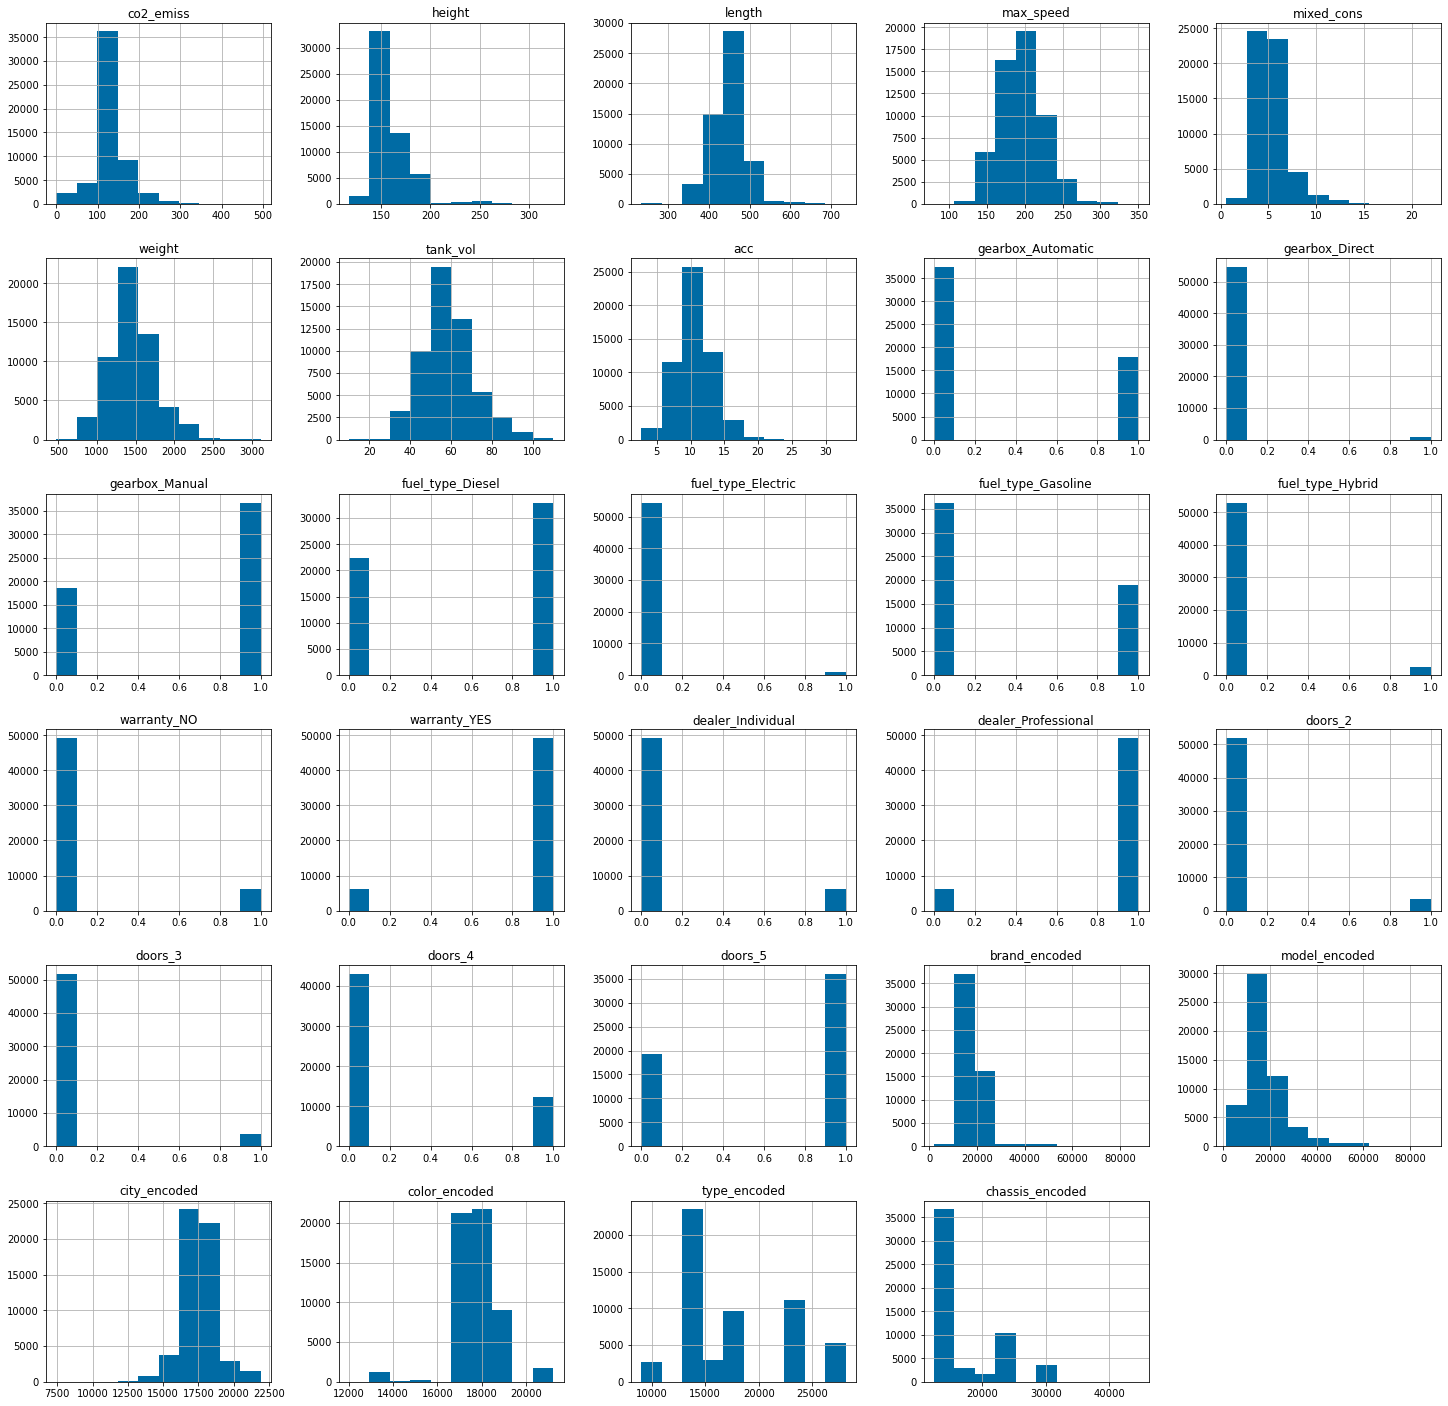

In [8]:
# Initial distribution of the features
X.hist(figsize=(25,25));

In [9]:
# Defining & applying Quantile Transformer
qt = QuantileTransformer(n_quantiles=500,
                         output_distribution='normal',
                         random_state=rng)

X_trf = qt.fit_transform(X)

X_trf = pd.DataFrame(X_trf, columns=X.columns)

X_trf.head()

,co2_emiss,height,length,max_speed,mixed_cons,weight,tank_vol,acc,gearbox_Automatic,gearbox_Direct,...,doors_2,doors_3,doors_4,doors_5,brand_encoded,model_encoded,city_encoded,color_encoded,type_encoded,chassis_encoded
0,-1.120443,0.285121,-2.877530,-2.143610,-0.679227,-2.897385,-2.456544,1.199172,5.199338,-5.199338,...,5.199338,-5.199338,-5.199338,-5.199338,-1.579469,-1.083566,-1.505232,-0.902609,5.199338,0.608153
1,1.303557,-1.624785,-0.685567,1.345832,1.358362,-0.272066,-0.085500,-1.377568,-5.199338,-5.199338,...,-5.199338,5.199338,-5.199338,-5.199338,0.329890,-0.367258,0.314018,-0.902609,5.199338,1.521013
2,-0.572277,-1.297705,0.171631,0.937119,-0.833062,0.438088,-1.220053,-0.794587,5.199338,-5.199338,...,-5.199338,-5.199338,5.199338,-5.199338,0.698331,0.833062,0.596109,5.199338,5.199338,1.521013
3,0.635580,0.540027,0.519795,0.651025,0.361889,1.079060,0.933230,-1.018128,5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,5.199338,0.698331,1.663600,-1.056848,-0.902609,5.199338,1.521013
4,3.744070,-2.967122,0.012559,-0.174181,3.436439,0.439471,1.120443,-2.877530,5.199338,-5.199338,...,5.199338,-5.199338,-5.199338,-5.199338,-1.183849,0.277283,-0.287738,-0.367258,5.199338,1.521013


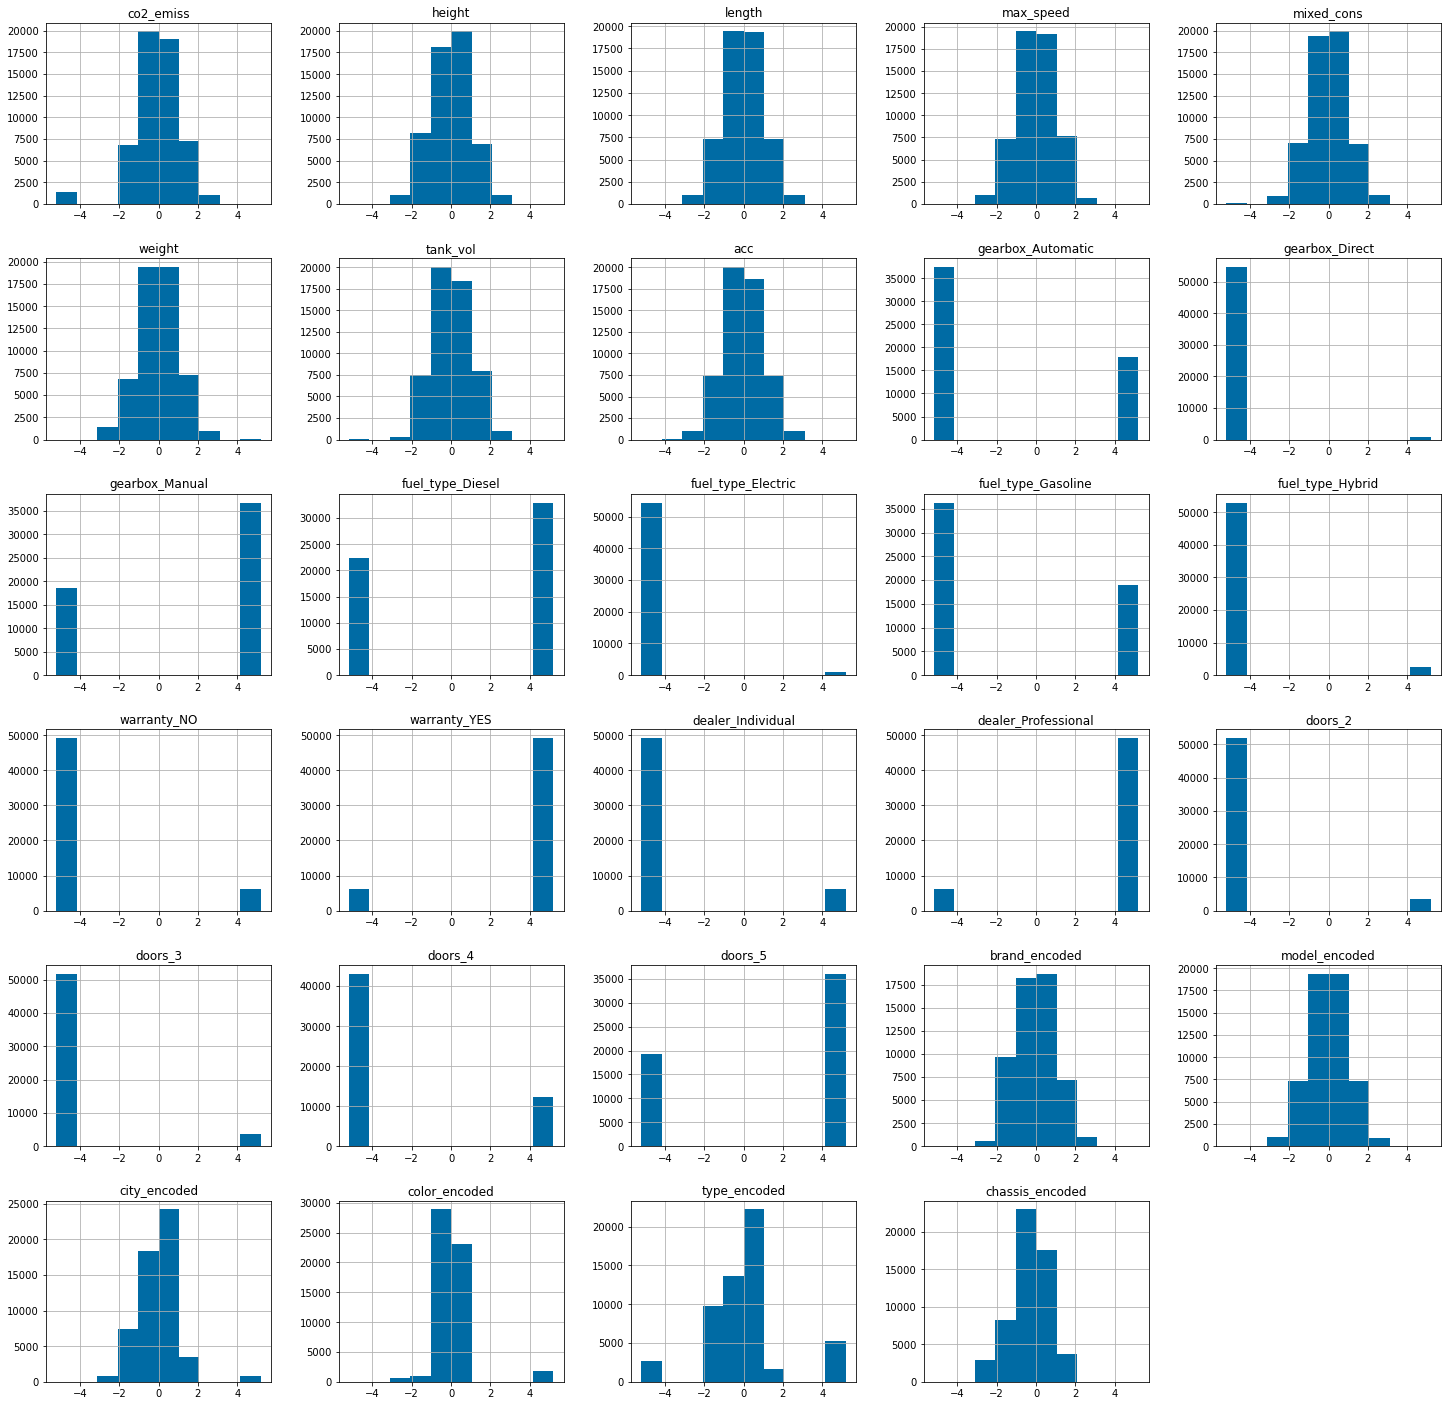

In [10]:
# Final distribution of the features
X_trf.hist(figsize=(25,25));

In [11]:
# Measuring the new performace
df_trf, results_trf = run_cv_reg(X_trf, y, models, evaluator='r2')
df_trf

Executing RF...
CV finished for RF
Executing XGB...
CV finished for XGB
Executing CB...
CV finished for CB


,model,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec
0,RF,0.8765,0.8780,0.8839,0.8839,0.0059,0.8876,0.8954,314.6678
1,XGB,0.8626,0.8687,0.8733,0.8723,0.0055,0.8756,0.8807,17.7702
2,CB,0.8609,0.8664,0.8701,0.8703,0.0054,0.8748,0.8793,91.2877


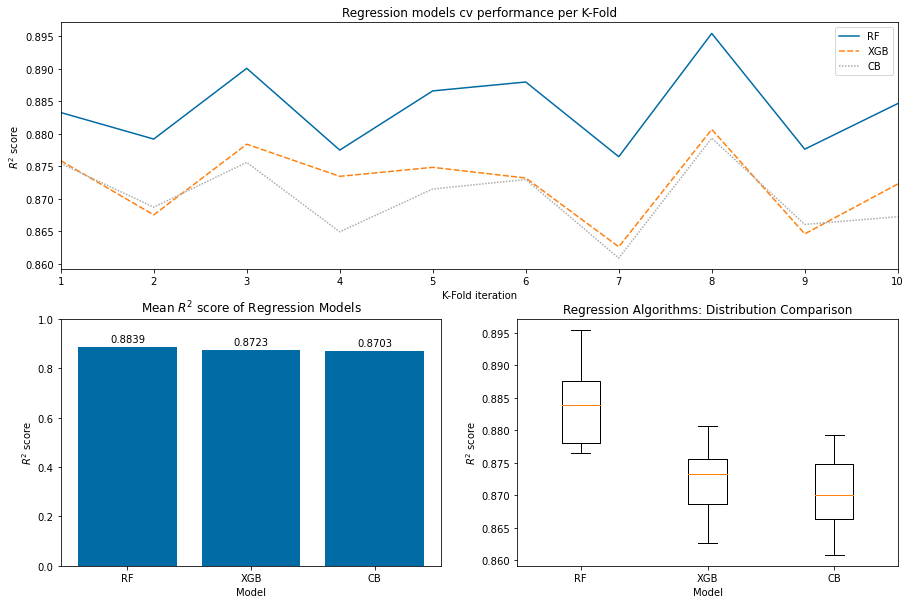

In [12]:
plot_model_eval(df=df_trf, results=results_trf)

### Transforming both features & target

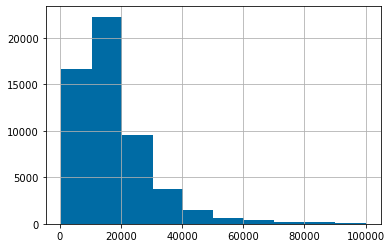

In [13]:
# Initial distribution of the target
y.hist();

Prices are not normal distributed, which is obvious in the graph above. It makes sense that most of the used cars are in a 10,000 to 20,000 €. Let's normalize it and see the impact in the model.

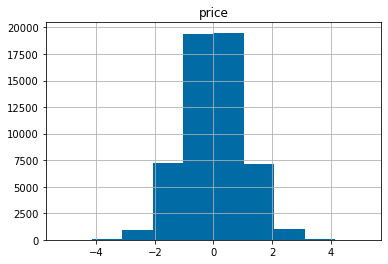

In [14]:
y_trf = qt.fit_transform(np.array(y).reshape(-1,1))

y_trf = pd.DataFrame(y_trf, columns=['price'])

# Final distribution of the target
y_trf.hist();

In [15]:
# Measuring the new performace
df_tgt, results_tgt = run_cv_reg(X_trf, y_trf.values[:, 0], models, evaluator='r2')
df_tgt

Executing RF...
CV finished for RF
Executing XGB...
CV finished for XGB
Executing CB...
CV finished for CB


,model,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec
0,RF,0.8800,0.8844,0.8863,0.8875,0.0054,0.8914,0.8984,300.3820
1,XGB,0.8730,0.8746,0.8790,0.8787,0.0042,0.8819,0.8847,18.9127
2,CB,0.8701,0.8733,0.8793,0.8776,0.0045,0.8810,0.8843,91.4364


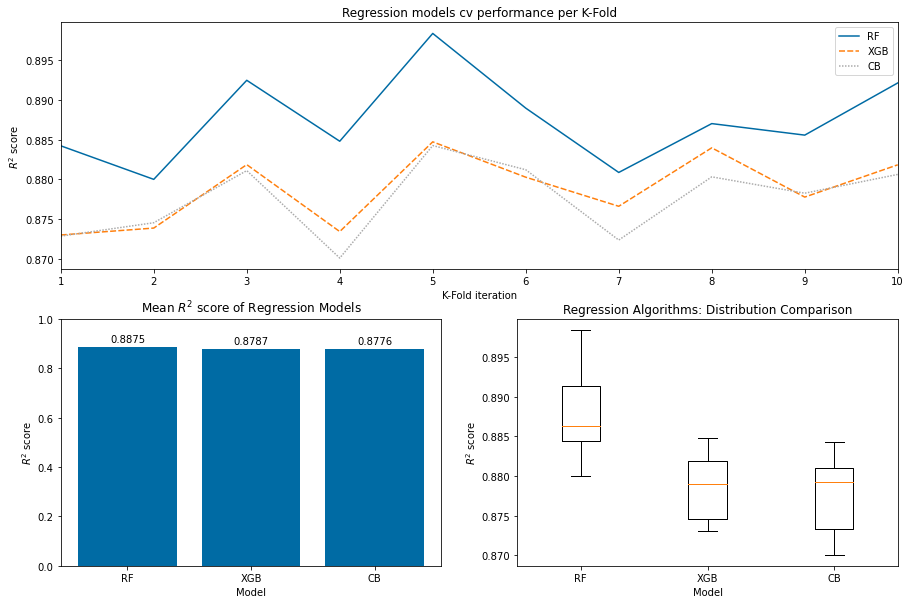

In [16]:
plot_model_eval(df=df_tgt, results=results_tgt)

## Performance after dividing in train & test sets
First, let's split the data into train & test set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng)

In [18]:
X_tt = qt.fit(X_train).transform(X_test)
y_tt = qt.fit(np.array(y_train).reshape(-1,1)).transform(np.array(y_test).reshape(-1,1))

X_tt = pd.DataFrame(X_trf, columns=X.columns)
y_tt = pd.DataFrame(y_trf, columns=['price']).values[:, 0]

print(X_tt.shape)
print(y_tt.shape)

(55366, 29)
(55366,)


In [19]:
# Measuring the new performace
df_tt, results_tt = run_cv_reg(X_tt, y_tt, models, evaluator='r2')
df_tt

Executing RF...
CV finished for RF
Executing XGB...
CV finished for XGB
Executing CB...
CV finished for CB


,model,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec
0,RF,0.8806,0.8841,0.8870,0.8876,0.0052,0.8908,0.8986,293.0765
1,XGB,0.8730,0.8746,0.8790,0.8787,0.0042,0.8819,0.8847,17.5412
2,CB,0.8701,0.8733,0.8793,0.8776,0.0045,0.8810,0.8843,91.8434


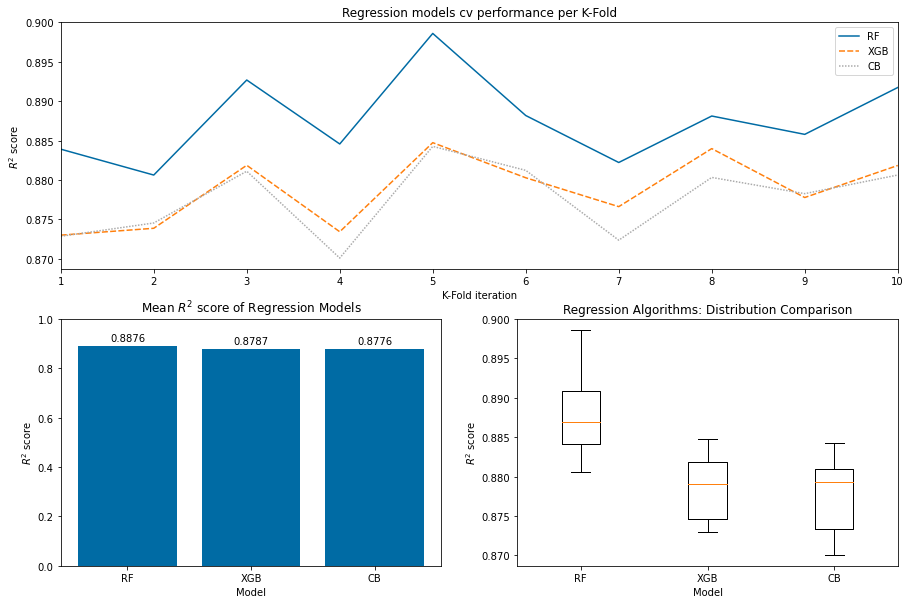

In [20]:
plot_model_eval(df=df_tt, results=results_tt)

## Preparing the transformed output

First, we implement a final cross validation to see if the performance enhance by applying a `Power Transformation` to the features `X`. It will be only applied to the best performer, `RandomForestRegressor`.

In [35]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [36]:
df.head()

,co2_emiss,height,length,max_speed,mixed_cons,weight,tank_vol,acc,price,gearbox_Automatic,...,doors_2,doors_3,doors_4,doors_5,brand_encoded,model_encoded,city_encoded,color_encoded,type_encoded,chassis_encoded
0,99,157,270,145,4.3,780,33,13.7,5500,1.0,...,1.0,0.0,0.0,0.0,11039.980916,10171.125628,15841.032810,16998.492107,28133.811134,20602.196957
1,179,140,426,235,7.6,1373,55,7.2,10900,0.0,...,0.0,1.0,0.0,0.0,17051.258362,13160.993789,18049.881613,16998.492107,28133.811134,31238.629315
2,109,142,453,222,4.2,1545,42,8.5,36100,1.0,...,0.0,0.0,1.0,0.0,23572.093803,23508.383973,18554.493671,21242.844857,28133.811134,31238.629315
3,142,162,467,212,5.4,1740,67,8.0,28000,1.0,...,0.0,0.0,0.0,1.0,23572.093803,36412.589552,16569.441935,16998.492107,28133.811134,31238.629315
4,488,123,446,189,21.0,1546,70,3.9,27990,1.0,...,1.0,0.0,0.0,0.0,12506.369048,17773.464491,17306.168324,17415.598758,28133.811134,31238.629315


In [38]:
rf = RandomForestRegressor()
cv = KFold(n_splits=10, shuffle=True, random_state=33)

scores = cross_val_score(rf, X_trf, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')

print('R2_score: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

R2_score: 0.885 (0.008)


We obtained a mean $R²\ score$ `0.001` higher than with the raw dataset () by using Power Transformations.

In [45]:
df_trf = X_trf
df_trf['price'] = y

df_trf = pd.DataFrame(df_trf, columns=df.columns)

df_trf.head()

,co2_emiss,height,length,max_speed,mixed_cons,weight,tank_vol,acc,gearbox_Automatic,gearbox_Direct,...,doors_3,doors_4,doors_5,brand_encoded,model_encoded,city_encoded,color_encoded,type_encoded,chassis_encoded,price
0,-1.120443,0.285121,-2.877530,-2.143610,-0.679227,-2.897385,-2.456544,1.199172,5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-1.579469,-1.083566,-1.505232,-0.902609,5.199338,0.608153,5500
1,1.303557,-1.624785,-0.685567,1.345832,1.358362,-0.272066,-0.085500,-1.377568,-5.199338,-5.199338,...,5.199338,-5.199338,-5.199338,0.329890,-0.367258,0.314018,-0.902609,5.199338,1.521013,10900
2,-0.572277,-1.297705,0.171631,0.937119,-0.833062,0.438088,-1.220053,-0.794587,5.199338,-5.199338,...,-5.199338,5.199338,-5.199338,0.698331,0.833062,0.596109,5.199338,5.199338,1.521013,36100
3,0.635580,0.540027,0.519795,0.651025,0.361889,1.079060,0.933230,-1.018128,5.199338,-5.199338,...,-5.199338,-5.199338,5.199338,0.698331,1.663600,-1.056848,-0.902609,5.199338,1.521013,28000
4,3.744070,-2.967122,0.012559,-0.174181,3.436439,0.439471,1.120443,-2.877530,5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-1.183849,0.277283,-0.287738,-0.367258,5.199338,1.521013,27990


In [47]:
output = r'../data/regression/cars_reg_trf.csv'

df_trf.to_csv(output, index=False)

## Conclusion


In this notebook, we covered how the `Quantile Transformer` can affect the performance of the `RF, XGB, CB` models. To this aim, it was tested how the final $R²\ score$ increased after transforming only the features and both features and target. Models positively reacted to this transformation, being the preprocessing of the whole data the best approach. 

After reviewing the performance of the model, the best configuration to be applied to the dataset was found. The $R²\ score$ metric improved for all the models, being `RandomForest` the best algorithm for this problem. Finally, the $R²\ score$ has enhanced from `0.8843` to `0.8876`. This suppose an improvement of `33 bps*`.

Since the performance of the `Random Forest Regressor` was way better than the rest of the Boosting algorithms, it will be the selected method for further analysis. Having a look at the data, the $mean\ R²\ score$ of `RF` was `89 bps` better than the $mean\ R²\ score$ of `XGB` and `29 bps` better than the $max\ R²\ score$, which was the second best performer. 

_* bps = basis points (i.e. 1% is 100bps)_